In [1]:
import arrow
import datetime
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import os
import pandas as pd
import pickle
import xarray as xr

%matplotlib inline

In [101]:
plt.rcParams['font.size'] = 14

## The Grid ##

In [35]:
mesh = nc.Dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
#mesh = nc.Dataset('../../../myResults/mesh_mask201702.nc')
gdepw = mesh.variables['gdepw_1d'][0]
bathy = nc.Dataset('/home/sallen/MEOPAR/grid/bathymetry_201702.nc')
#bathy = nc.Dataset('../../../myResults/bathymetry_201702.nc')
lats = bathy.variables['nav_lat'][:]
lons = bathy.variables['nav_lon'][:]
gdept = mesh.variables['gdept_1d'][0]
print (gdept)
mesh.close()
bathy.close()

[  0.50000027   1.50000314   2.5000115    3.50003055   4.50007042
   5.50015083   6.50031022   7.50062342   8.50123623   9.50243254
  10.5047653   11.50931127  12.51816684  13.53541212  14.56898216
  15.63428737  16.76117342  18.00713456  19.48178514  21.38997868
  24.10025665  28.22991514  34.68575798  44.51772486  58.48433368
  76.58558445  98.06295924 121.8665184  147.08945807 173.11448217
 199.57304923 226.26030574 253.06663733 279.93454976 306.83419736
 333.75016973 360.6745318  387.60320347 414.53408835 441.46610968]


## Get the Data ##

In [72]:
fullsouth_all_2015 = pd.read_csv('fullsouth_all_2015.csv', index_col=0)
fullsouth_all_2016 = pd.read_csv('fullsouth_all_2016.csv', index_col=0)
fullsouth_all_2017 = pd.read_csv('fullsouth_all_2017.csv', index_col=0)

south_gulfislands = pd.read_csv('south_gulfislands.csv', index_col=0)
south_puget = pd.read_csv('south_puget.csv', index_col=0)
south_discovery = pd.read_csv('south_discovery.csv', index_col=0)

fullnorth_all_2015 = pd.read_csv('fullnorth_all_2015.csv', index_col=0)
fullnorth_all_2016 = pd.read_csv('fullnorth_all_2016.csv', index_col=0)
fullnorth_all_2017 = pd.read_csv('fullnorth_all_2017.csv', index_col=0)

north_gulfislands = pd.read_csv('north_gulfislands.csv', index_col=0)
north_puget = pd.read_csv('north_puget.csv', index_col=0)
north_discovery = pd.read_csv('north_discovery.csv', index_col=0)

In [73]:
for df in [fullsouth_all_2015, fullsouth_all_2016, fullsouth_all_2017,
          fullnorth_all_2015, fullnorth_all_2016, fullnorth_all_2017]:
    df.index = pd.to_datetime(df.index, format="%Y-%m-%d %H:%M:%S+00:00")

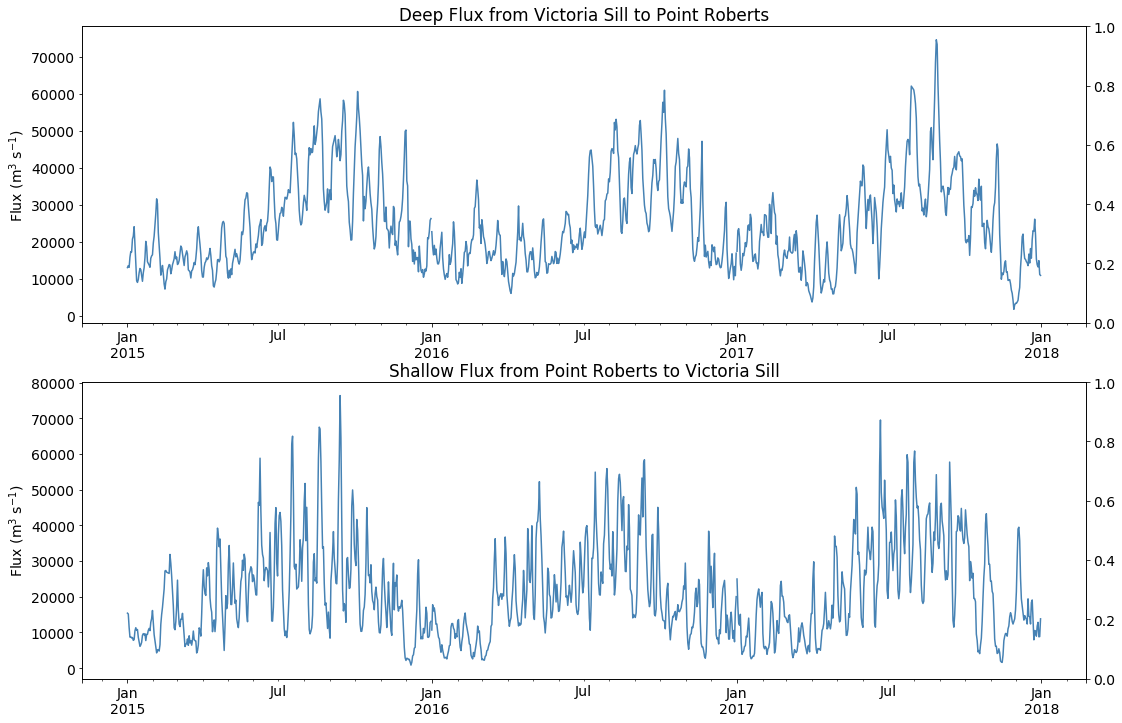

In [102]:
fig, ax = plt.subplots(2, 1, figsize=(18, 12))
fullsouth_all_2015.transport.plot(ax=ax[0], label="South to North 2015", legend=False, color='steelblue')
fullnorth_all_2015.transport.plot(ax=ax[1], label="North to South (shallow) 2015", legend=False, color='steelblue')
fullsouth_all_2016.plot(ax=ax[0], y='transport', label="South to North 2016", legend=False, color='steelblue')
fullnorth_all_2016.plot(ax=ax[1], y='transport', label="North to South (shallow) 2016", legend=False, color='steelblue')
fullsouth_all_2017.plot(ax=ax[0], y='transport', label="South to North 2017", legend=False, color='steelblue')
fullnorth_all_2017.plot(ax=ax[1], y='transport', label="North to South (shallow) 2017", legend=False, color='steelblue')
#low_pass_tide.plot(ax=ax2, c='r')
#ax.set_xlim(fullsouth_transport.index[0], time[-1])
ax[0].set_title("Deep Flux from Victoria Sill to Point Roberts")
ax[1].set_title("Shallow Flux from Point Roberts to Victoria Sill")
for ax in [ax[0], ax[1]]:
    ax2 = ax.twinx()
    ax.set_ylabel('Flux (m$^3$ s$^{-1}$)')
#    low_pass_tide.plot(ax=ax2, color = 'peru')

In [26]:
print('from Vic')
print ('to PR', 0.5*(fullsouth_all_2015.transport.mean() + fullsouth_all_2016.transport.mean()))
print ('to GI', south_gulfislands.transport.mean())
print ('to PS/D', south_puget.transport.mean() + south_discovery.transport.mean())
print ('total', 0.5*(fullsouth_all_2015.transport.mean() + fullsouth_all_2016.transport.mean()) +
      south_gulfislands.transport.mean() + south_puget.transport.mean() + south_discovery.transport.mean())

from Vic
to PR 24939.30762099509
to GI 2494.3419571996405
to PS/D 34508.15828209351
total 61941.80786028824


In [28]:
print('from PR')
print ('to VS', 0.5*(fullnorth_all_2015.transport.mean() + fullnorth_all_2016.transport.mean()))
print ('to GI', north_gulfislands.transport.mean())
print ('to PS/D', north_puget.transport.mean() + north_discovery.transport.mean())
print ('total', 0.5*(fullnorth_all_2015.transport.mean() + fullnorth_all_2016.transport.mean())+
      north_gulfislands.transport.mean()+north_puget.transport.mean() + north_discovery.transport.mean())

from PR
to VS 20848.996024600692
to GI 6422.191094518156
to PS/D 3978.501865761992
total 31249.68898488084


In [27]:
back_south_pointroberts = pd.read_csv('back_south_pointroberts.csv')
back_south_gulfislands = pd.read_csv('back_south_gulfislands.csv')
back_south_puget = pd.read_csv('back_south_puget.csv')
back_south_discovery = pd.read_csv('back_south_discovery.csv')
print('into VS')
print ('from PR', back_south_pointroberts.transport.mean())
print ('from GI', back_south_gulfislands.transport.mean())
print ('from PS/D', back_south_puget.transport.mean() + back_south_discovery.transport.mean())
print ('total',  back_south_pointroberts.transport.mean()+
      back_south_gulfislands.transport.mean() + back_south_puget.transport.mean() + back_south_discovery.transport.mean())

into VS
from PR 21238.71507128748
from GI 7609.7508646156375
from PS/D 38501.20922983506
total 67349.67516573818


In [29]:
back_north_victoriasill = pd.read_csv('back_north_victoriasill.csv')
back_north_gulfislands = pd.read_csv('back_north_gulfislands.csv')
back_north_puget = pd.read_csv('back_north_puget.csv')
back_north_discovery = pd.read_csv('back_north_discovery.csv')
print('into PR')
print ('from VS', back_north_victoriasill.transport.mean())
print ('from GI', back_north_gulfislands.transport.mean())
print ('from PS/D', back_north_puget.transport.mean() + back_north_discovery.transport.mean())
print ('total', back_north_victoriasill.transport.mean()+back_north_gulfislands.transport.mean()+
      back_north_puget.transport.mean() + back_north_discovery.transport.mean())

into PR
from VS 25495.45177727469
from GI 3347.188255068052
from PS/D 2452.704112571053
total 31295.344144913797


## Depths ##

In [41]:
print ('to PR', 0.25*(fullsouth_all_2015.init_depth.mean() + fullsouth_all_2016.init_depth.mean())
       + 0.25*(fullsouth_all_2015.final_depth.mean() + fullsouth_all_2016.final_depth.mean()))
print ('to PR', 0.5*(fullsouth_all_2015.init_depth.mean() + fullsouth_all_2016.init_depth.mean()),
       0.5*(fullsouth_all_2015.final_depth.mean() + fullsouth_all_2016.final_depth.mean()))
print ('to VS', 0.25*(fullnorth_all_2015.init_depth.mean() + fullnorth_all_2016.init_depth.mean())
       + 0.25*(fullnorth_all_2015.final_depth.mean() + fullnorth_all_2016.final_depth.mean()))
print ('to GI', 0.5*(south_gulfislands.final_depth.mean() + south_gulfislands.init_depth.mean()))
print ('at GI', south_gulfislands.final_depth.mean())
print ('to PS/D', 0.5*(south_puget.final_depth.mean() + south_puget.init_depth.mean()))

to PR -72.97870315641413
to PR -62.87296003498079 -83.08444627784746
to VS -28.058060635002715
to GI -51.70378937724074
at GI -40.6183850599234
to PS/D -41.81546851736172


## Calculation of Tides moved to "Calculate Tides" ##
Here just read them

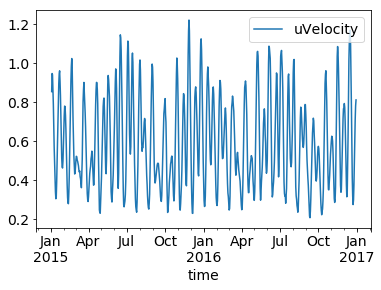

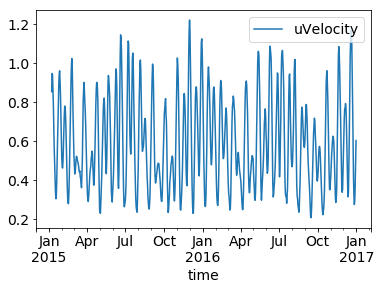

In [134]:
low_pass_tide = pd.read_csv('low_pass_tide.csv', index_col=0)
low_pass_tide.index = pd.to_datetime(low_pass_tide.index, format="%Y-%m-%d")
low_pass_tide.plot()

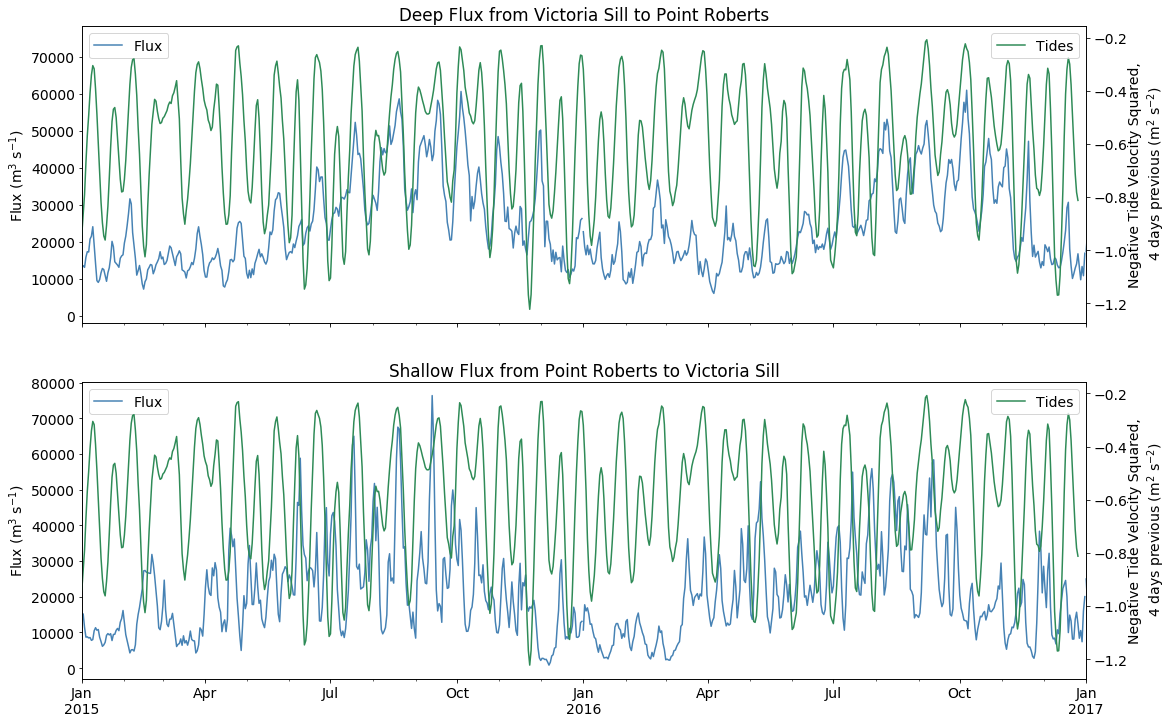

In [160]:
fig, ax = plt.subplots(2, 1, figsize=(18, 12))
fullsouth_all_2015.transport.plot(ax=ax[0], label="", legend=False, color='steelblue')
fullnorth_all_2015.transport.plot(ax=ax[1], label="", legend=False, color='steelblue')
fullsouth_all_2016.plot(ax=ax[0], y='transport', label="", legend=False, color='steelblue')
fullnorth_all_2016.plot(ax=ax[1], y='transport', label="", legend=False, color='steelblue')
fullsouth_all_2017.plot(ax=ax[0], y='transport', label="Flux", legend=False, color='steelblue')
fullnorth_all_2017.plot(ax=ax[1], y='transport', label="Flux", legend=False, color='steelblue')
ax[0].set_title("Deep Flux from Victoria Sill to Point Roberts")
ax[1].set_title("Shallow Flux from Point Roberts to Victoria Sill")
for ax in [ax[0], ax[1]]:
    ax2 = ax.twinx()
    ax.set_ylabel('Flux (m$^3$ s$^{-1}$)')
    (-low_pass_tide.shift(-4)).plot(ax=ax2, y='uVelocity', color = 'seagreen', legend=False, label='Tides')
    ax.set_xlim(datetime.datetime(2015, 1, 1), datetime.datetime(2017, 1, 1))
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax2.set_ylabel('Negative Tide Velocity Squared,\n 4 days previous (m$^2$ s$^{-2}$)')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
ax2 = ax.twinx()
lag = 0
ii, jj = 150-min(0,lag), 290-min(0,lag)
ax.plot(range(ii, jj), fullnorth_transport['transport'][ii+lag:jj+lag], 'o-')
ax2.plot(range(ii, jj), low_pass_tide['uVelocity'][ii:jj], 'r')

## Summer Deep Water Variability ##

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
ax2 = ax.twinx()
lag = -3
ii, jj = 190, 300
ax.plot(range(ii, jj),fullsouth_transport['transport'][ii+lag:jj+lag])
ax2.plot(range(ii, jj), -low_pass_tide['uVelocity'][ii:jj], 'r')

## Spring Deep Water Variability ##

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
ax2 = ax.twinx()
lag = -3
ii, jj = 100, 190
ax.plot(range(ii, jj),fullsouth_transport['transport'][ii+lag:jj+lag])
ax2.plot(range(ii, jj), -low_pass_tide['uVelocity'][ii:jj], 'r')

## Winter Deep Water Variability : note change in lag

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
ax2 = ax.twinx()
lag = -5
ii, jj = 0-lag, 100
ax.plot(range(ii, jj),fullsouth_transport['transport'][ii+lag:jj+lag])
ax2.plot(range(ii, jj), -low_pass_tide['uVelocity'][ii:jj], 'r')

# Impact of Density Difference #

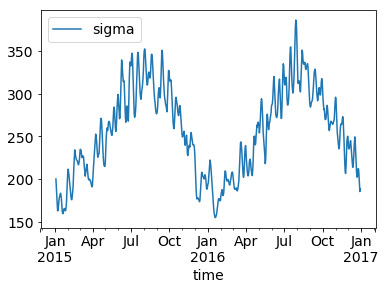

In [106]:
msouth = pd.read_csv('south_sigma.csv', index_col=0)
mnorth = pd.read_csv('north_sigma.csv', index_col=0)
msouth.index = pd.to_datetime(msouth.index, format="%Y-%m-%d")
mnorth.index = pd.to_datetime(mnorth.index, format="%Y-%m-%d")
(msouth-mnorth).plot()

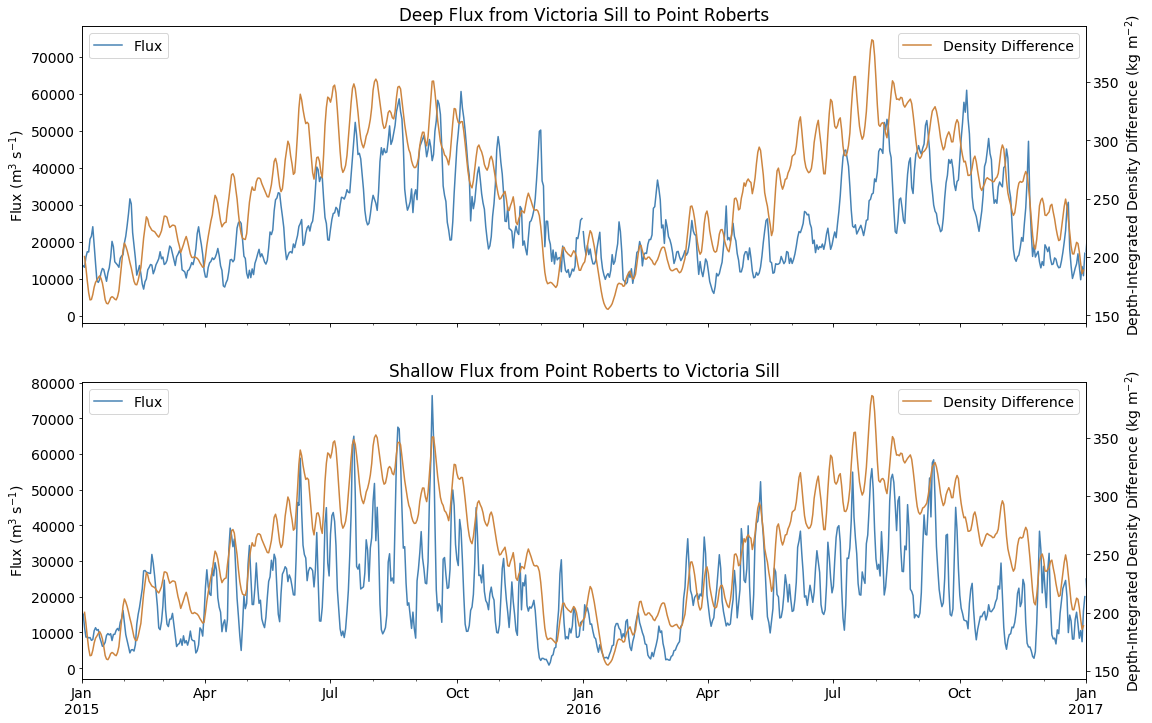

In [156]:
fig, ax = plt.subplots(2, 1, figsize=(18, 12))
fullsouth_all_2015.transport.plot(ax=ax[0], label="", legend=False, color='steelblue')
fullnorth_all_2015.transport.plot(ax=ax[1], label="", legend=False, color='steelblue')
fullsouth_all_2016.plot(ax=ax[0], y='transport', label="", legend=False, color='steelblue')
fullnorth_all_2016.plot(ax=ax[1], y='transport', label="", legend=False, color='steelblue')
flux_line_u = fullsouth_all_2017.plot(ax=ax[0], y='transport', label="Flux", legend=False, color='steelblue')
flux_line_l = fullnorth_all_2017.plot(ax=ax[1], y='transport', label="Flux", legend=False, color='steelblue')
#low_pass_tide.plot(ax=ax2, c='r')
#ax.set_xlim(fullsouth_transport.index[0], time[-1])
ax[0].set_title("Deep Flux from Victoria Sill to Point Roberts")
ax[1].set_title("Shallow Flux from Point Roberts to Victoria Sill")
for ax in [ax[0], ax[1]]:
    ax2 = ax.twinx()
    ax.set_ylabel('Flux (m$^3$ s$^{-1}$)')
    density_line = (msouth-mnorth).plot(ax=ax2, y='sigma', legend=False, label='Density Difference',  color = 'peru')
    ax.set_xlim(datetime.datetime(2015, 1, 1), datetime.datetime(2017, 1, 1))
    ax2.set_ylabel('Depth-Integrated Density Difference (kg m$^{-2}$)')
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

# Wind #

In [173]:
wind = pd.read_csv('low_pass_wind.csv', index_col=0)
wind.index = pd.to_datetime(wind.index, format="%Y-%m-%d")

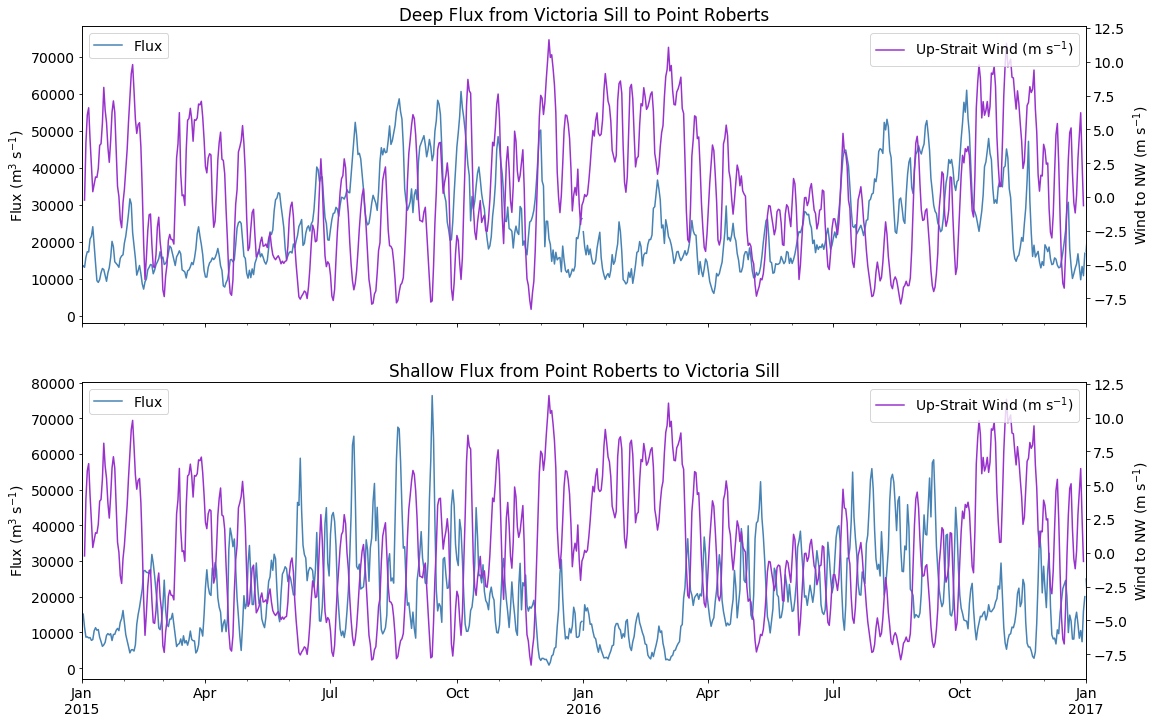

In [174]:
fig, ax = plt.subplots(2, 1, figsize=(18, 12))
fullsouth_all_2015.transport.plot(ax=ax[0], label="", legend=False, color='steelblue')
fullnorth_all_2015.transport.plot(ax=ax[1], label="", legend=False, color='steelblue')
fullsouth_all_2016.plot(ax=ax[0], y='transport', label="", legend=False, color='steelblue')
fullnorth_all_2016.plot(ax=ax[1], y='transport', label="", legend=False, color='steelblue')
flux_line_u = fullsouth_all_2017.plot(ax=ax[0], y='transport', label="Flux", legend=False, color='steelblue')
flux_line_l = fullnorth_all_2017.plot(ax=ax[1], y='transport', label="Flux", legend=False, color='steelblue')
#low_pass_tide.plot(ax=ax2, c='r')
#ax.set_xlim(fullsouth_transport.index[0], time[-1])
ax[0].set_title("Deep Flux from Victoria Sill to Point Roberts")
ax[1].set_title("Shallow Flux from Point Roberts to Victoria Sill")
for ax in [ax[0], ax[1]]:
    ax2 = ax.twinx()
    ax.set_ylabel('Flux (m$^3$ s$^{-1}$)')
    wind.plot(ax=ax2, y='wind', legend=False, label='Up-Strait Wind (m s$^{-1}$)',  color = 'darkorchid')
    ax.set_xlim(datetime.datetime(2015, 1, 1), datetime.datetime(2017, 1, 1))
    ax2.set_ylabel('Wind to NW (m s$^{-1}$)')
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')